In [1]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=18)
import numpy as np
import warnings


from hyperfet.devices import SCMOSFET,VO2,HyperFET
import hyperfet.approximations as appr
from hyperfet.references import si, mixed_vo2_params

In [2]:
# Parameters given for Figure 3

#vo2_params={
#    "rho_m":si("5e-4 ohm cm"),
#    "rho_i":si("80 ohm cm"),
#    "J_MIT":si("2e6 A/cm^2"),
#    "J_IMT":si(".55e4 A/cm^2"),
#    "V_met":0,
#    "L":si("8nm"),
#    "W":si("14nm"),
#    "T":si("14nm")
#}
#vo2=VO2(**vo2_params)

VDD=.5

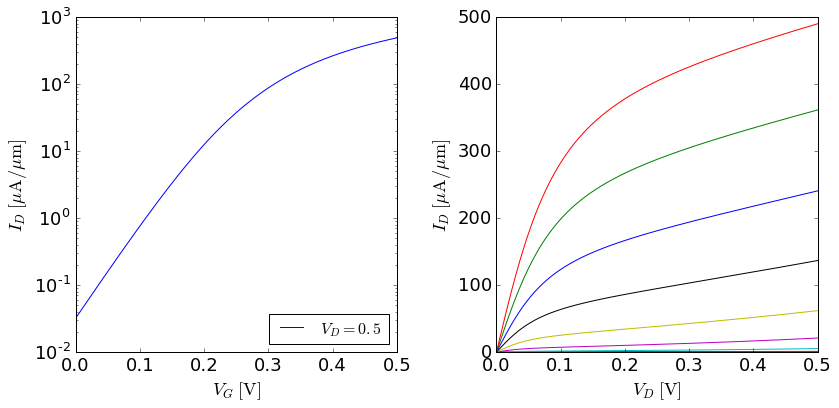

In [3]:
fet=None
@interact(VT0=FloatSlider(value=.35,min=0,max=1,step=.05,continuous_update=False),
          W=FloatSlider(value=70,min=10,max=100,step=10,continuous_update=False),
          Cinv_vxo=FloatSlider(value=2500,min=1000,max=5000,step=400,continuous_update=False),
          SS=FloatSlider(value=.070,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=0,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.8,min=0,max=4,step=.1,continuous_update=False),
          VDD=FloatSlider(value=.5,min=.3,max=1,step=.05,continuous_update=False),
          VDsats=FloatSlider(value=.1,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=.1,min=0,max=.5,step=.05,continuous_update=False),
          log10Gleak=FloatSlider(value=-12,min=-14,max=-5,step=1,continuous_update=False)
         )
def show_HEMT(VT0,W,Cinv_vxo,SS,alpha,beta,VDsats,VDD,delta,log10Gleak):
    global fet
    plt.figure(figsize=(12,6))
    fet=SCMOSFET(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    
    plt.subplot(121)
    VD=np.array(VDD)
    VG=np.linspace(0,.5,500)
    I=fet.ID(VD=VD,VG=VG)
    plt.plot(VG,I/fet.W,label=r"$V_D={:.2g}$".format(VDD))
    plt.yscale('log')
    plt.xlabel(r"$V_G\;\mathrm{[V]}$")
    plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
    plt.legend(loc='lower right',fontsize=16)
    
    plt.subplot(122)
    VD=np.linspace(0,VDD,500)
    VG=np.linspace(0,VDD,10)
    I=fet.ID(VD=VD,VG=VG)
    plt.plot(VD,I.T/fet.W)
    plt.xlabel(r"$V_D\;\mathrm{[V]}$")
    plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
    #plt.legend([r"$V_G={:.2g}$".format(vg) for vg in VG],loc='lower right',fontsize=16)
    
    plt.tight_layout()

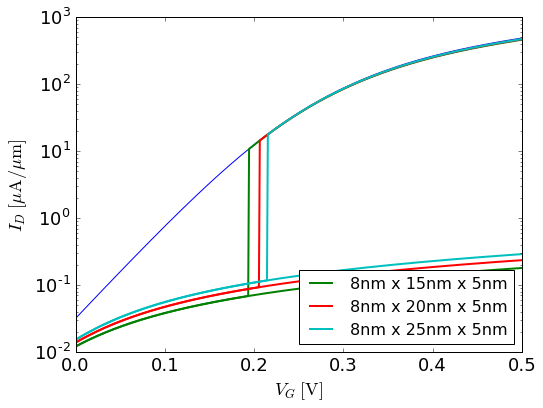

In [8]:
VDD=.5

VD=np.array(VDD)
VG=np.linspace(0,.5,500)

plt.figure(figsize=(8,6))
plt.plot(VG,fet.ID(VD,VG)/fet.W)

for LWT in ["8nm x 15nm x 5nm", "8nm x 20nm x 5nm", "8nm x 25nm x 5nm"]:
    L,W,T=[si(x) for x in LWT.split("x")]
    vo2=VO2(L=L,W=W,T=T,**mixed_vo2_params)
    hf=HyperFET(fet,vo2)
    
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    l=plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,label=LWT,linewidth=2)[0]
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,linewidth=2,color=l.get_color())
    
plt.yscale('log')
plt.xlabel(r"$V_G\;\mathrm{[V]}$")
plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
plt.legend(loc='lower right',fontsize=16)

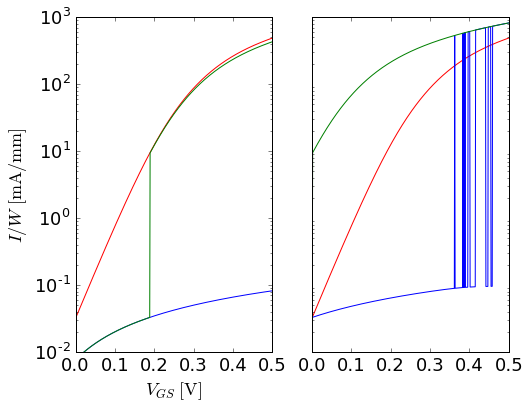

In [12]:
out=HTML()
@interact(L=FloatSlider(value=16,min=1,max=30,step=1,continuous_update=False),
          W=FloatSlider(value=13,min=1,max=30,step=1,continuous_update=False),
          T=FloatSlider(value= 5,min=1,max=30,step=1,continuous_update=False))
def show_hf(L,W,T):
    plt.figure(figsize=(12,6))
    
    vo2=VO2(L=L*1e-9,W=W*1e-9,T=T*1e-9,**mixed_vo2_params)
    hf=HyperFET(fet,vo2)
    shift=appr.shift(hf,VDD)
    fet2=fet.shifted(shift)
    hf2=HyperFET(fet2,vo2)
    
    VD=np.array(VDD)
    VG=np.linspace(0,VDD,500)

    plt.subplot(131)
    I=np.ravel(fet.ID(VD=VD,VG=VG))
    plt.plot(VG,I/fet.W,'r')
    
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If)],If[~np.isnan(If)]/fet.W,'b')
    plt.plot(VG[~np.isnan(Ib)],Ib[~np.isnan(Ib)]/fet.W,'g')
    
    
    plt.yscale('log')
    plt.ylim(1e-2,1e3)
    plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
    plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
    
    
    plt.subplot(132)    
    plt.plot(VG,I/fet2.W,'r')
    If2,Ib2=[np.ravel(i) for i in hf2.I_double(VD=VD,VG=VG)]
    plt.plot(VG[~np.isnan(If2)],If2[~np.isnan(If2)]/fet2.W,'b')
    plt.plot(VG[~np.isnan(Ib2)],Ib2[~np.isnan(Ib2)]/fet2.W,'g')
    
    
    plt.yscale('log')
    plt.ylim(1e-2,1e3)
    plt.yticks([])
    
    
    out.value="Approx shift is {:.2g}mV, which equates the IOFF within {:.2g}%."\
    "  This is expected to increase ION by {:.2g}% and actually increases it by {:.2g}%"\
    .format(shift*1e3,(If2[0]-I[0])/I[0]*100,appr.shiftedgain(hf,VDD)*100-100,(If2[-1]-I[-1])/I[-1]*100)
display(out)